In [99]:
import sys, os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
softmax = torch.nn.Softmax(dim=1)
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    top_k_accuracy_score,
    classification_report,
    confusion_matrix
)
import random
from pathlib import Path
from tqdm import tqdm
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from typing import List, Tuple
import torch.nn.functional as F

In [72]:
# Compute absolute path to the `src/` folder
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH     = os.path.join(PROJECT_ROOT, "src")

if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

from utils import get_dataloaders, load_model, evaluate_model, print_metrics, plot_confusion_matrix, show_sample_predictions, plot_random_image_with_label_and_prediction

In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [114]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


In [10]:
COUNTRIES = ["Albania","Andorra","Argentina","Australia","Austria","Bangladesh","Belgium","Bhutan","Bolivia","Botswana","Brazil","Bulgaria","Cambodia","Canada","Chile","Colombia","Croatia","Czechia","Denmark","Dominican Republic","Ecuador","Estonia","Eswatini","Finland","France","Germany","Ghana","Greece","Greenland","Guatemala","Hungary","Iceland","Indonesia","Ireland","Israel","Italy","Japan","Jordan","Kenya","Kyrgyzstan","Latvia","Lesotho","Lithuania","Luxembourg","Malaysia","Mexico","Mongolia","Montenegro","Netherlands","New Zealand","Nigeria","North Macedonia","Norway","Palestine","Peru","Philippines","Poland","Portugal","Romania","Russia","Senegal","Serbia","Singapore","Slovakia","Slovenia","South Africa","South Korea","Spain","Sri Lanka","Sweden","Switzerland","Taiwan","Thailand","Turkey","Ukraine","United Arab Emirates","United Kingdom","United States","Uruguay"]
num_classes = len(COUNTRIES)
project_root   = Path().resolve().parent

### Data

In [146]:
test_root = project_root/ "data" / "final_datasets" / "test"
test_loader = get_dataloaders(test_root, batch_size=32)

In [147]:
get_dataloaders(test_root, batch_size=32)

### Load model

In [148]:
model = load_model(model_path=project_root / "models" / "resnet_finetuned" / "main.pth", device=device)

/Users/michelangelonardi/Desktop/Università/Master/Bocconi Master/Year 1/Semester2/Computer Vision & Image processing/Final - project/rainbot/src/utils.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

### Get base model prediction probs

In [149]:
def get_prob(true_lbl, probs_i, class_names, n=5):
    topk     = probs_i.argsort()[::-1][:3]
    class_names = np.array(class_names)
    topk_str = ", ".join(f"{class_names[k]} ({probs_i[k]:.2f})" for k in topk)
    print(f"True: {true_lbl:20s}  ↔  Pred Top-3: {topk_str}")

In [158]:
# get random image 
all_countries = [d for d in test_root.iterdir() if d.is_dir()]
country = random.choice(all_countries).name
img_files = list((test_root / country).glob("*.jpg"))
img_path = random.choice(img_files)

img = Image.open(img_path).convert("RGB")

# Preprocess and predict
input_tensor = transform(img).unsqueeze(0).to(device)  # add batch dimension
with torch.no_grad():
    outputs = model(input_tensor)
    pred_idx = outputs.argmax(dim=1).item()
    pred_label = COUNTRIES[pred_idx]

probs = softmax(outputs).cpu().numpy()

get_prob(country, np.squeeze(probs), COUNTRIES, n=1)

True: Chile                 ↔  Pred Top-3: Chile (0.17), Argentina (0.15), Croatia (0.12)


### Get segments

In [161]:
MODEL_NAME = "nvidia/segformer-b0-finetuned-cityscapes-768-768"

feature_extractor = SegformerFeatureExtractor.from_pretrained(MODEL_NAME)
seg_model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME).eval()

/opt/anaconda3/envs/cv_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/anaconda3/envs/cv_env/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/opt/anaconda3/envs/cv_env/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [165]:
CITYSCAPES_LABELS = {
    0: 'road',        1: 'sidewalk', 2: 'building', 4: 'fence',
    5: 'pole',        6: 'traffic_light', 7: 'traffic_sign',
    8: 'vegetation',  9: 'terrain',  11: 'person',
    13: 'car',       17: 'bicycle'
}

TARGET_CLASSES = {'bicycle','building','car','fence','person','pole',
                  'road','sidewalk','terrain','traffic_light','traffic_sign','vegetation'}

In [166]:
def segment_image_per_class(
    image: Image.Image
) -> List[Tuple[str, Image.Image]]:
    """
    Runs semantic segmentation on `image` and returns a list of
    (class_name, masked_image) for each detected class in TARGET_CLASSES.
    Each masked_image is black everywhere except pixels of that class.
    """
    # 1) Preprocess
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = seg_model(**inputs)
    logits = outputs.logits  # shape: (1, num_classes, H, W)
    
    # 2) Argmax to get predicted label per pixel
    pred = torch.argmax(logits.squeeze(), dim=0).cpu().numpy()  # shape: (H, W)
    
    h, w = pred.shape
    img_np = np.array(image.resize((w, h)))  # align sizes
    
    results = []
    for label_id, class_name in CITYSCAPES_LABELS.items():
        if class_name not in TARGET_CLASSES:
            continue
        mask = (pred == label_id)
        if not mask.any():
            continue  # this class not present
        
        # Create a blank canvas
        canvas = np.zeros_like(img_np)
        # Copy only masked pixels
        canvas[mask] = img_np[mask]
        masked_img = Image.fromarray(canvas)
        results.append((class_name, masked_img))
    
    return results

In [167]:
segments = segment_image_per_class(img)

for class_name, seg_img in segments:
    print("Found:", class_name)
    seg_img.show()

Found: road
Found: sidewalk
Found: fence
Found: pole
Found: traffic_sign
Found: vegetation
Found: terrain
Found: person
Found: car


In [ ]:
# plot segmented images 
def plot_segmented_images(image: Image.Image, segments: List[Tuple[str, Image.Image]]):
    fig, axes = plt.subplots(1, len(segments) + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    for ax, (class_name, seg_img) in zip(axes[1:], segments):
        ax.imshow(seg_img)
        ax.set_title(class_name)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

### Call submodels 

In [196]:
def classify_segments(segments):
    """
    segments: List of (class_name, PIL.Image) from segment_image_per_class.
    For each, loads ../models/resnet_finetuned_{class_name}/main.pth,
    infers top-5, and prints results.
    """
    for class_name, img in segments:
        if class_name not in ["terrain", "road", "vegetation", "building", "fence"]:
            continue
        model_dir = os.path.join("..", "models", f"resnet_finetuned_{class_name}")
        weights_path = os.path.join(model_dir, "main.pth")
        if not os.path.exists(weights_path):
            print(f"[!] Missing model for {class_name} at {weights_path}")
            continue

        # 1) Load checkpoint and determine num_classes
        ckpt = torch.load(weights_path, map_location="cpu")
        state = ckpt.get('model_state') or ckpt.get('state_dict') or ckpt
        out_features = list(state.keys())[-2]  # e.g. 'fc.weight'
        # Extract weight tensor shape from checkpoint
        fc_weight = state['fc.weight']
        num_classes = fc_weight.shape[0]

        # 2) Build same ResNet and load weights
        clf = models.resnet50(pretrained=False)
        clf.fc = torch.nn.Linear(clf.fc.in_features, num_classes)
        clf.load_state_dict(state)
        clf.to(device).eval()

        # 3) Preprocess and run
        inp = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = clf(inp)
            probs = F.softmax(logits, dim=1).cpu().squeeze().numpy()

        # 4) Top-5 prediction
        top5_idx = probs.argsort()[::-1][:5]
        print(f"\n[{class_name}] Top-5 predictions:")
        for idx in top5_idx:
            print(f"  {COUNTRIES[idx]}: {probs[idx]:.3f}")

### Example

In [215]:
# get random image 
all_countries = [d for d in test_root.iterdir() if d.is_dir()]
country = random.choice(all_countries).name
img_files = list((test_root / country).glob("*.jpg"))
img_path = random.choice(img_files)

img = Image.open(img_path).convert("RGB")

# Preprocess and predict
input_tensor = transform(img).unsqueeze(0).to(device)  # add batch dimension
with torch.no_grad():
    outputs = model(input_tensor)
    pred_idx = outputs.argmax(dim=1).item()
    pred_label = COUNTRIES[pred_idx]

probs = softmax(outputs).cpu().numpy()

get_prob(country, np.squeeze(probs), COUNTRIES, n=1)

True: Sweden                ↔  Pred Top-3: Poland (0.40), Czechia (0.11), Serbia (0.09)


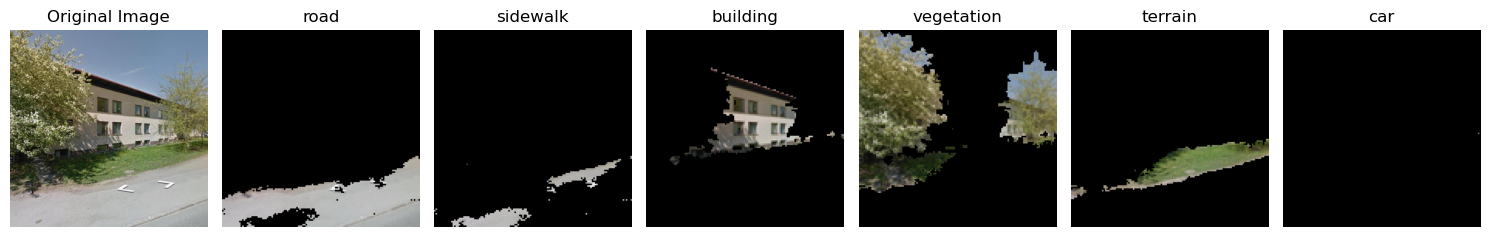

In [216]:
segments = segment_image_per_class(img)
plot_segmented_images(img, segments)

In [217]:
classify_segments(segments)

/var/folders/d5/5853p9zd6pvbjb8vz92bhmnc0000gn/T/ipykernel_3578/1636984017.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(weights_path, map_location=


[road] Top-5 predictions:
  Ecuador: 0.054
  Bulgaria: 0.049
  Andorra: 0.044
  Greece: 0.041
  Peru: 0.041

[building] Top-5 predictions:
  Poland: 0.363
  Switzerland: 0.133
  Ukraine: 0.126
  Slovakia: 0.081
  Lithuania: 0.059

[vegetation] Top-5 predictions:
  Bhutan: 0.263
  Andorra: 0.057
  Argentina: 0.027
  Iceland: 0.025
  Taiwan: 0.024

[terrain] Top-5 predictions:
  New Zealand: 0.120
  Australia: 0.119
  Canada: 0.102
  Sweden: 0.086
  Finland: 0.076
